In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from model_simulator import ARXSimulator
from mpc_controller import MPCController
from plotly.subplots import make_subplots
from tqdm import tqdm
import random
%load_ext autoreload

In [2]:
B = [-0.00091497,  0.14029288]
A = [-1.04411331, 0.00942735,  0.00399007,  0.05331014]

horizon = 8
P = 0.1
Q = 1e3

# initialize array to store simulation results
t_sim = 288
u_past_sim = np.zeros(4)
# u_past_sim = np.ones(4) * 12
y_past_sim = np.ones(4) * 20
y_ref_sim = np.array([])
y_ref = 45
mpc = MPCController(A, B, P, Q, horizon)
arx = ARXSimulator(A, B)

In [3]:
y_ref_sim = np.append(y_ref_sim, y_past_sim)
for t in tqdm(range(0,t_sim)):
    # print('u_past_sim: ', u_past_sim)
    # print('y_past_sim: ', y_past_sim)

    u_sim, y_sim = mpc.simulate(u_past_sim[-2:], y_past_sim[-4:], y_ref)
    if u_sim is  None:
        break
    u_past_sim = np.append(u_past_sim, u_sim[len(A)])
    mwh_hat = arx.MW_to_MWh([u_sim[len(A)]], y_past_sim, u_past_sim[-2:])
    y_past_sim = np.append(y_past_sim, mwh_hat)
    y_ref_sim = np.append(y_ref_sim,y_ref)
    # if t % 35 ==0 and t > 0:
    #     y_ref = random.choice([45, 20, 60, 15])


  0%|          | 0/288 [00:00<?, ?it/s]

100%|██████████| 288/288 [00:13<00:00, 20.96it/s]


Horizon (hours):  2.0  P:  0.1  Q:  1000.0


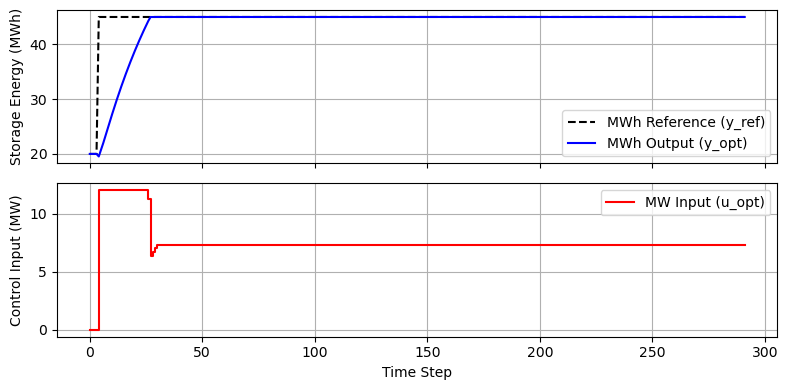

In [4]:
print('Horizon (hours): ', horizon/4, ' P: ', P, ' Q: ', Q )

time = range(len(y_past_sim))
fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# Plot y_ref and y_output
axs[0].plot(time,y_ref_sim, label="MWh Reference (y_ref)", linestyle="--", color="black")
# axs[0].axhline(y_ref, label = 'Y- reference')
axs[0].plot(time, y_past_sim, label="MWh Output (y_opt)", color="blue")
axs[0].set_ylabel("Storage Energy (MWh)")
axs[0].legend()
axs[0].grid(True)

# Plot u_control
axs[1].step(time, u_past_sim, label="MW Input (u_opt)", where="post", color="red")
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Control Input (MW)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [8]:
# actual plots from the csv files
folder_path = r"D:\ms\January 2024\Thesis\Boiler-Bidding-model\Datasets\PHLIT_After_Update.xlsx"
schedule = pd.read_excel(folder_path)

In [10]:
schedule.columns

Index(['Local time', 'L11 HR (MW)', 'D41 VP MDC (MW)', 'L11 VP (MW)',
       'L02 VP (MW)', 'L31 VP (MW)', 'L11 EK (MW)', 'L11 Sonfor (MW)',
       'L11 K5 (MW)', 'L11 K8 (MW)', 'Lastprognose (MW)', 'Akku (MWh)',
       'Total Produktion (MW)', 'Unnamed: 13', 'Unnamed: 14'],
      dtype='object')

In [ ]:
schedule['other MW'] = schedule['L11 HR (MW)']+ schedule['D41 VP MDC (MW)'] + schedule['L11 VP (MW)']+ schedule['L02 VP (MW)']+ schedule['L31 VP (MW)']+ schedule['L11 Sonfor (MW)']+ schedule['L11 K5 (MW)']+ schedule['L11 K8 (MW)']
schedule['Lastprognose (MW)'] = schedule['Lastprognose (MW)'].ffill()


In [20]:
fig = go.Figure()

# Add step plots
fig.add_trace(go.Scatter(x=schedule['Local time'], y=schedule['Akku (MWh)'], mode='lines', line=dict(shape='hv', color='blue'), name="MWh"))
fig.add_trace(go.Scatter(x=schedule['Local time'], y=schedule['L11 EK (MW)'], mode='lines', line=dict(shape='hv', color='red'), name="EK Boiler Prod MW", yaxis="y2"))
fig.add_trace(go.Scatter(x=schedule['Local time'], y=schedule['Lastprognose (MW)'], mode='lines', line=dict(shape='hv', color='black'), name="Forecast MW", yaxis="y2"))
fig.add_trace(go.Scatter(x=schedule['Local time'], y=schedule['other MW'], mode='lines', line=dict(shape='hv', color='green'), name="Other Prod MW", yaxis="y2"))
fig.add_trace(go.Scatter(x=schedule['Local time'], y=schedule['Total Produktion (MW)'], mode='lines', line=dict(shape='hv', color='maroon'), name="Total Prod MW", yaxis="y2"))

# Layout settings
fig.update_layout(
    title=" L11 Heat storage energy [MWh] and 'Heat load forecast [MW]'",
    xaxis_title="Time [15 min]",
    yaxis_title="L11 Heat storage energy [MWh]",
    yaxis2=dict(
        title="Heat Load [MW]",
        overlaying="y",
        side="right"
    ),
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    template="plotly_white"
)

# Show plot
fig.show()

In [7]:
# test Digital Twin (Model_simulator) using the schedule data
B = [-0.00091497,  0.14029288]
A = [-1.04411331, 0.00942735,  0.00399007,  0.05331014]
boiler_model = ARXSimulator(A, B)
Mwh_output = np.array([])
delay = 4

# simulated with 4 y_lags correction
for t in range(4, len(schedule['L11 EK plan [MW]']), delay):
    y_past_sim = schedule['L11 Heat storage energy [MWh]'][t-4:t] # for y(t-1) to y(t-4)
    for k in range(t, t + delay):
        u_past_sim = schedule['L11 EK plan [MW]'][k-1:k+1] # for u(t) and u(t-1)
        mwh_hat = boiler_model.MW_to_MWh([schedule['L11 EK plan [MW]'][k]], y_past_sim[-4:], u_past_sim[-2:])
        y_past_sim = np.append(y_past_sim, mwh_hat)
        Mwh_output = np.append(Mwh_output, mwh_hat)


In [8]:
fig = go.Figure()

# Add step plots
fig.add_trace(go.Scatter(x=schedule['UTC'][4:], y=schedule['L11 Heat storage energy [MWh]'][4:], mode='lines', line=dict(shape='hv', color='blue'), name="Actual MWh"))
fig.add_trace(go.Scatter(x=schedule['UTC'][4:], y=schedule['L11 EK plan [MW]'][4:], mode='lines', line=dict(shape='hv', color='black'), name="Input MW", yaxis="y2"))
fig.add_trace(go.Scatter(x=schedule['UTC'][4:], y=Mwh_output, mode='lines', line=dict(shape='hv', color='red'), name="Predicted MWh"))

# Layout settings
fig.update_layout(
    title=" L11 Heat storage energy [MWh] and 'Heat load forecast [MW]'",
    xaxis_title="Time [15 min]",
    yaxis_title="L11 Heat storage energy [MWh]",
    yaxis2=dict(
        title="Heat Load [MW]",
        overlaying="y",
        side="right"
    ),
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    template="plotly_white"
)

# Show plot
fig.show()

In [15]:
# test MPC Controller using the schedule data
B = [-0.00091497,  0.14029288]
A = [-1.04411331, 0.00942735,  0.00399007,  0.05331014]

horizon = 8
P = 10
Q = 1e3

# initialize array to store simulation results
t_sim = len(schedule['L11 Heat storage energy [MWh]'][4:])
y_ref_sim = schedule['L11 Heat storage energy [MWh]'].values

mpc = MPCController(A, B, P, Q, horizon)
arx = ARXSimulator(A, B)

In [16]:
sim = 8
y_simulated = schedule['L11 Heat storage energy [MWh]'][:4].values
u_simulated = schedule['L11 EK plan [MW]'][:4].values
# simulated with 4 y_lags correction
for t in tqdm(range(4, t_sim, sim)): # full simulation range in steps of 8
    y_past_sim = schedule['L11 Heat storage energy [MWh]'][t-4:t].values
    u_past_sim = schedule['L11 EK plan [MW]'][t-4:t].values
    for k in range(t, t + sim):   # MPC sim loop 8 steps 2 hours
        u_sim, y_sim = mpc.simulate(u_past_sim[-2:], y_past_sim[-4:], y_ref_sim[k])
        if u_sim is None:
            break
        u_past_sim = np.append(u_past_sim, u_sim[len(A)])
        mwh_hat = arx.MW_to_MWh([u_sim[len(A)]], y_past_sim[-4:], u_past_sim[-2:])
        y_past_sim = np.append(y_past_sim, mwh_hat)

        # save simulated value
        y_simulated = np.append(y_simulated, mwh_hat)
        u_simulated = np.append(u_simulated, u_sim[len(A)])


  8%|▊         | 6/71 [00:02<00:22,  2.95it/s]

Solver status: infeasible


 18%|█▊        | 13/71 [00:04<00:25,  2.29it/s]

Solver status: infeasible


 34%|███▍      | 24/71 [00:07<00:08,  5.87it/s]

Solver status: infeasible
Solver status: infeasible
Solver status: infeasible


 37%|███▋      | 26/71 [00:08<00:08,  5.49it/s]

Solver status: infeasible
Solver status: infeasible


 44%|████▎     | 31/71 [00:09<00:11,  3.34it/s]

Solver status: infeasible


 55%|█████▍    | 39/71 [00:11<00:05,  5.80it/s]

Solver status: infeasible
Solver status: infeasible
Solver status: infeasible


 79%|███████▉  | 56/71 [00:15<00:01,  9.00it/s]

Solver status: infeasible
Solver status: infeasible
Solver status: infeasible
Solver status: infeasible
Solver status: infeasible
Solver status: infeasible
Solver status: infeasible


 87%|████████▋ | 62/71 [00:15<00:00, 13.54it/s]

Solver status: infeasible
Solver status: infeasible
Solver status: infeasible
Solver status: infeasible
Solver status: infeasible


 96%|█████████▌| 68/71 [00:15<00:00, 18.73it/s]

Solver status: infeasible
Solver status: infeasible
Solver status: infeasible
Solver status: infeasible
Solver status: infeasible
Solver status: infeasible


100%|██████████| 71/71 [00:15<00:00,  4.46it/s]

Solver status: infeasible
Solver status: infeasible
Solver status: infeasible


In [17]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.2, subplot_titles=["L11 Heat Storage Energy [MWh]", "Heat Load [MW]"])
# Add step plots
fig.add_trace(go.Scatter(x=schedule['UTC'][4:], y=schedule['L11 Heat storage energy [MWh]'], mode='lines', line=dict(shape='hv', color='blue'), name="Reference MWh"), row=1, col=1)
fig.add_trace(go.Scatter(x=schedule['UTC'][4:], y=y_simulated, mode='lines', line=dict(shape='hv', color='green'), name="Output MWh sim"), row=1, col=1)
fig.add_trace(go.Scatter(x=schedule['UTC'][4:], y=schedule['L11 EK plan [MW]'], mode='lines', line=dict(shape='hv', color='black'), name="Actual Input MW", yaxis="y2"), row=2, col=1)
fig.add_trace(go.Scatter(x=schedule['UTC'][4:], y=u_simulated, mode='lines', line=dict(shape='hv', color='red'), name="MW output of MPC", yaxis="y2"), row=2, col=1)

# Layout settings
fig.update_layout(
    title=" L11 Heat storage energy [MWh] and 'Heat load forecast [MW]'",
    xaxis_title="Time [15 min]",
    xaxis2_title="Time [15 min]",
    xaxis=dict(showgrid=True),
    xaxis2=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    template="plotly_white"
)

# Show plot
fig.show()